# **[GD-10] Transformer로 번역기 만들기**
---

# **🗼 목차**
Step 0. 라이브러리 불러오기  
Step 1. 데이터 불러오기  
Step 2. 데이터 정제 및 토큰화  
Step 3. 모델 설계  
Step 4. 훈련하기  
Step 5. 모델 학습하기  
🌞 회고

# **Step 0. 라이브러리 불러오기**
---

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

# print(tensorflow.__version__)
# print(numpy.__version__)
# print(matplotlib.__version__)

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/content/drive/MyDrive/AIFFEL/[GD-10]/transformer/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


# **Step 1. 데이터 불러오기**
---

In [4]:
kor_path = '/content/drive/MyDrive/AIFFEL/[GD-10]/transformer/korean-english-park.train.tar/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/AIFFEL/[GD-10]/transformer/korean-english-park.train.tar/korean-english-park.train.en'

In [5]:
with open(kor_path, "r") as f:
    kor_raw = f.read().splitlines()

print("Korean Data Size:", len(kor_raw))
print("Korean Example:")

for sen in kor_raw[0:10]: print(">>", sen)

Korean Data Size: 94123
Korean Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.


In [6]:
with open(eng_path, "r") as f:
    eng_raw = f.read().splitlines()

print("English Data Size:", len(eng_raw))
print("English Example:")

for sen in eng_raw[0:10]: print(">>", sen)

English Data Size: 94123
English Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
>> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
>> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or w

# **Step 2. 데이터 정제 및 토큰화**
---

## **2.1 중복 제거**
- 데이터의 병렬 쌍이 흐트러지지 않게 중복 제거하기 위해서 `zip 함수`를 사용한다.
- 중복을 제거하기 위해 `set`으로 데이터 형태를 변경하였다.

In [7]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    set_data = set(zip(kor, eng))
    cleaned_corpus = list(set_data)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [8]:
cleaned_corpus[1]

('이란의 영국군 나포 사건으로 인한 긴장 고조로 걸프 지역 석유공급에 대한 우려가 상승, 29일 유가는 6개월래 최고수준을 기록했다.',
 'Oil held near its highest close in over six months on Thursday as traders weighed rising risk to Gulf supplies from mounting tension between Iran and the West.')

In [9]:
print(len(cleaned_corpus))

78968


## **2.2 데이터 정제**

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   # \1 : 앞의 첫 번째 그룹을 뜻함 / 첫 번째 그룹에 있는 문자 앞 뒤로 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)     # 여러 개의 공백을 하나의 공백으로 변경
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)   # 영어, 한글, ?.!, 제외한 것들을 공백으로 변경

    sentence = sentence.strip()   # 문자열 양 끝에 있는 공백 제거

    return sentence

## **2.3 토큰화**
토큰화에는 `Sentencepiece`를 활용해보자.

In [11]:
pip install sentencepiece

특수 토큰의 인덱스를 `<PAD>` : 0 / `<BOS>` : 1 / `<EOS>` : 2 / `<UNK>` : 3 와 같이 지정한다.  
그리고 sentencepiece 모델을 활용하여 토큰화하는 `generator_tokenizer`를 정의해보자.

In [12]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # 학습 후 저장된 model 파일 경로
    temp_file = '/content/drive/MyDrive/AIFFEL/[GD-10]/temp_{lang}_txt'

    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
    '--input={} --vocab_size={} --model_prefix=spm_{} --pad_id={} --bos_id={} --eos_id={} --unk_id={}'.format(temp_file, vocab_size, lang, pad_id, bos_id, eos_id, unk_id)    
)
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('spm_{}.model'.format(lang))

    return tokenizer

위에서 정의한 `preprocess_sentence`를 활용하여 한글 말뭉치 `kor_corpus`와 영문 말뭉치 `eng_corpus`를 분리하여 정제해보자.

In [13]:
kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    tmp_kor = preprocess_sentence(kor)
    tmp_eng = preprocess_sentence(eng, s_token = True, e_token = True)

    kor_corpus.append(tmp_kor)
    eng_corpus.append(tmp_eng)
    
print(len(kor_corpus))
print(len(eng_corpus))

78968
78968


단어사전의 크기를 `20,000`으로 지정하여 위에서 정의한 `generate_tokenizer`로 토큰화해보자.

In [14]:
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000

kor_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
eng_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
eng_tokenizer.set_encode_extra_options("bos:eos")

True

## **2.4 학습용 데이터 완성**
토크나이저를 활용하여 토큰의 길이가 50 이하인 데이터만을 선별하여 corpus를 각각 구축하고 텐서로 변환시켜보자.

In [15]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위함

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = kor_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = eng_tokenizer.EncodeAsIds(eng_corpus[idx])

    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# **Step 3. 모델 설계**
---

## **3.1 내부 모듈 구현하기**
이번 프로젝트는 트랜스포머를 완성하는 데에 필요한 모듈을 하나하나 만든 후 조립하여 완성하는 방식으로 진행해보자.

### **3.1.1 Positional Encoding**

In [16]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


### **3.1.2 Multi-Head Attention**
Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성된다.

Embedding된 입력을 Head 수로 분할하는 `split_heads()`, 분할된 입력으로부터 Attention 값을 구하는 `scaled_dot_product_attention()`, 연산이 종료되고 분할된 Head를 다시 하나로 결합하는 `combine_heads()` 등 여러 개의 서브 모듈이 있다.  
이 서브 모듈들을 `MultiHeadAttention` 클래스를 정의하여 모두 포함시킬 것이다.  


In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):      # 분할된 입력으로부터 Attention 값을 구함
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)     # 생성된 마스크를 처리

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):         # Embedding된 입력을 Head 수로 분할
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):     # 연산이 종료되고 분할된 Head를 다시 하나로 결합
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### **3.1.3 Position-wise Feed-Forward Network**
`[batch_size x length x d_model]`의 입력을 받아 `w_1`이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 `w_2`를 통해 512차원으로 되돌리는 과정이다

In [18]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


## **3.2 모듈 조립하기**
마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 `tf.keras.layers.Layer` 클래스를 상속받아 레이어 클래스로 정의해주면 된다.  
(직전에 정의한 MultiHeadAttention 레이어와 같은 방법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있다.)


### **3.2.1 Encoder 레이어 구현하기**

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### **3.2.3 Decoder 레이어 구현하기**
Decoder에서는 두 번의 Attention이 진행되므로 반환되는 Attention도 2개이다.

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### **3.2.4 Encoder 정의**

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


### **3.2.5 Decoder 정의**

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### **3.2.6 Transformer 완성하기**
정의된 Encoder와 Decoder를 가지고 최종적으로 `Transformer`를 완성해보자.

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## **3.3 모델 밖의 조력자**

### **3.3.1 Masking**

In [24]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):   # Attention 시 <PAD> 토큰에 Attention을 주는 것을 방지
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


# **Step 4. 훈련하기**
---

### **4.1 '2 Layer'를 가지는 `Transformer`를 선언해보자.**

In [25]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size = 20000,
    tgt_vocab_size = 20000,
    pos_len = 50,
    dropout=0.2
    )

### **4.2 Learning Rate Scheduler를 선언해보자.**

In [26]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

print("슝=3")

슝=3


In [27]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### **4.3 Loss 함수를 정의해보자.**

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)  # mask는 정답지에서 <PAD> 토큰을 찾아내 그 부분에 대한 Loss를 구하지 않도록 하는 역할을 함
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


### **4.4 time_step 함수를 정의해보자.**

In [29]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

# **Step 5. 모델 학습하기**
---

In [30]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [31]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [32]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [33]:
from tqdm import tqdm_notebook

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, kor_tokenizer, eng_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president barack obama is a big president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the two days of the biggest .
Input: 커피는 필요 없다.
Predicted translation: the very important .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the storm was killed by the hostages .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president obama is a lot of .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of cities were in the city of city .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee coffee does not be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of city .
Input: 커피는 필요 없다.
Predicted translation: we need to do not need for anyway .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported monday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of freetown .
Input: 커피는 필요 없다.
Predicted translation: the coffee cannot be needed to be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , deaths were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president , the president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city hall , the city of urban .
Input: 커피는 필요 없다.
Predicted translation: coffee is a coffee for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens were in the mountains .
Input: 커피는 필요 없다.
Predicted translation: need to keep their votes .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed sunday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obamas is widely picked up .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city of urban .
Input: 커피는 필요 없다.
Predicted translation: the need is no reason for .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , seven were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is sometimes urban cities .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen others were injured .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city was made into the hands of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh of the seven deaths occurred .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s a president on the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they now rial in the big cities .
Input: 커피는 필요 없다.
Predicted translation: need to coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , seven others were injured .


Input: 오바마는 대통령이다.
Predicted translation: he s a president on the president .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


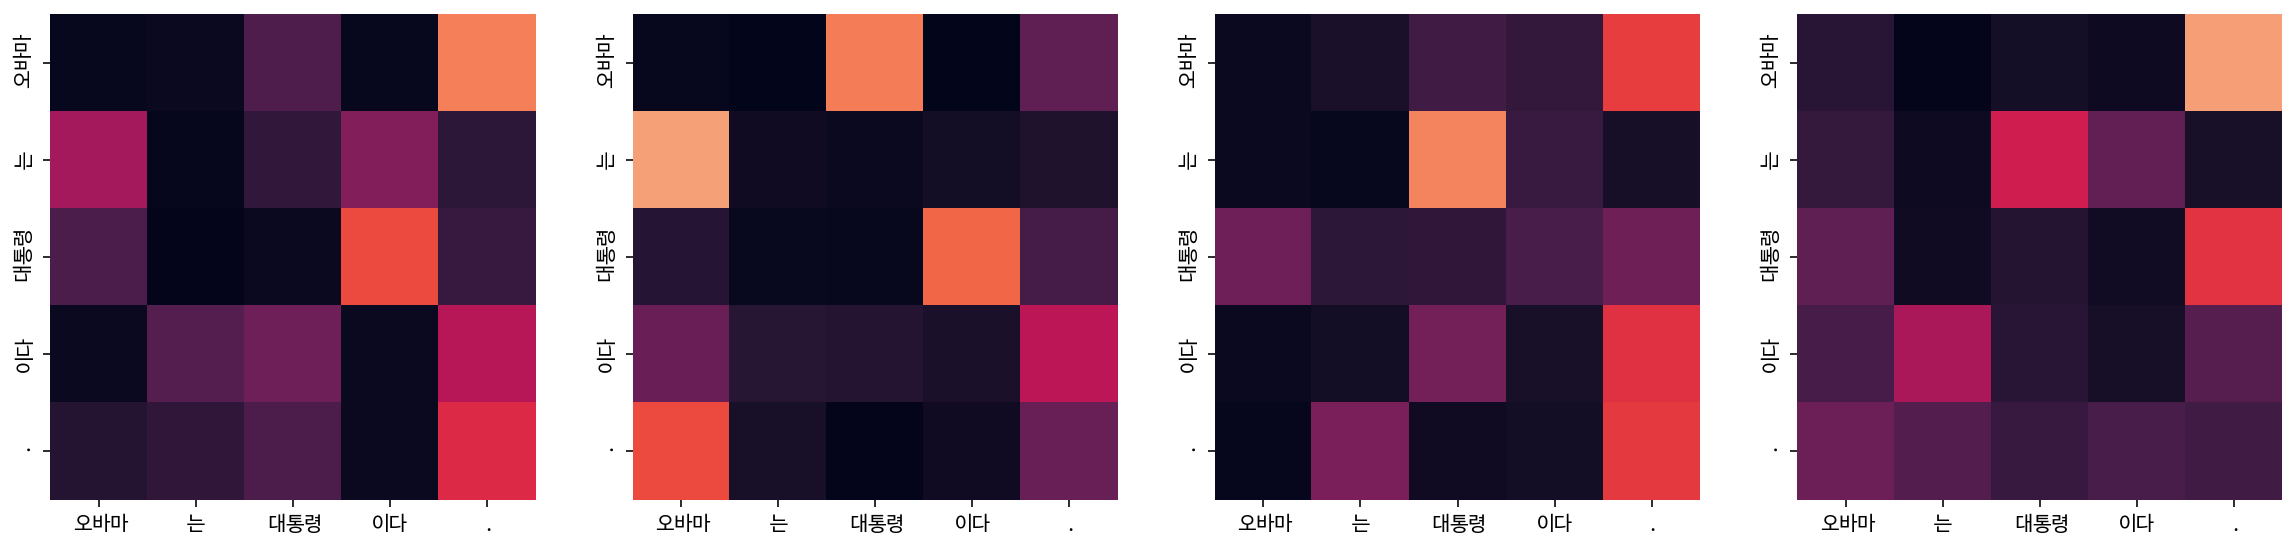

Encoder Layer 2


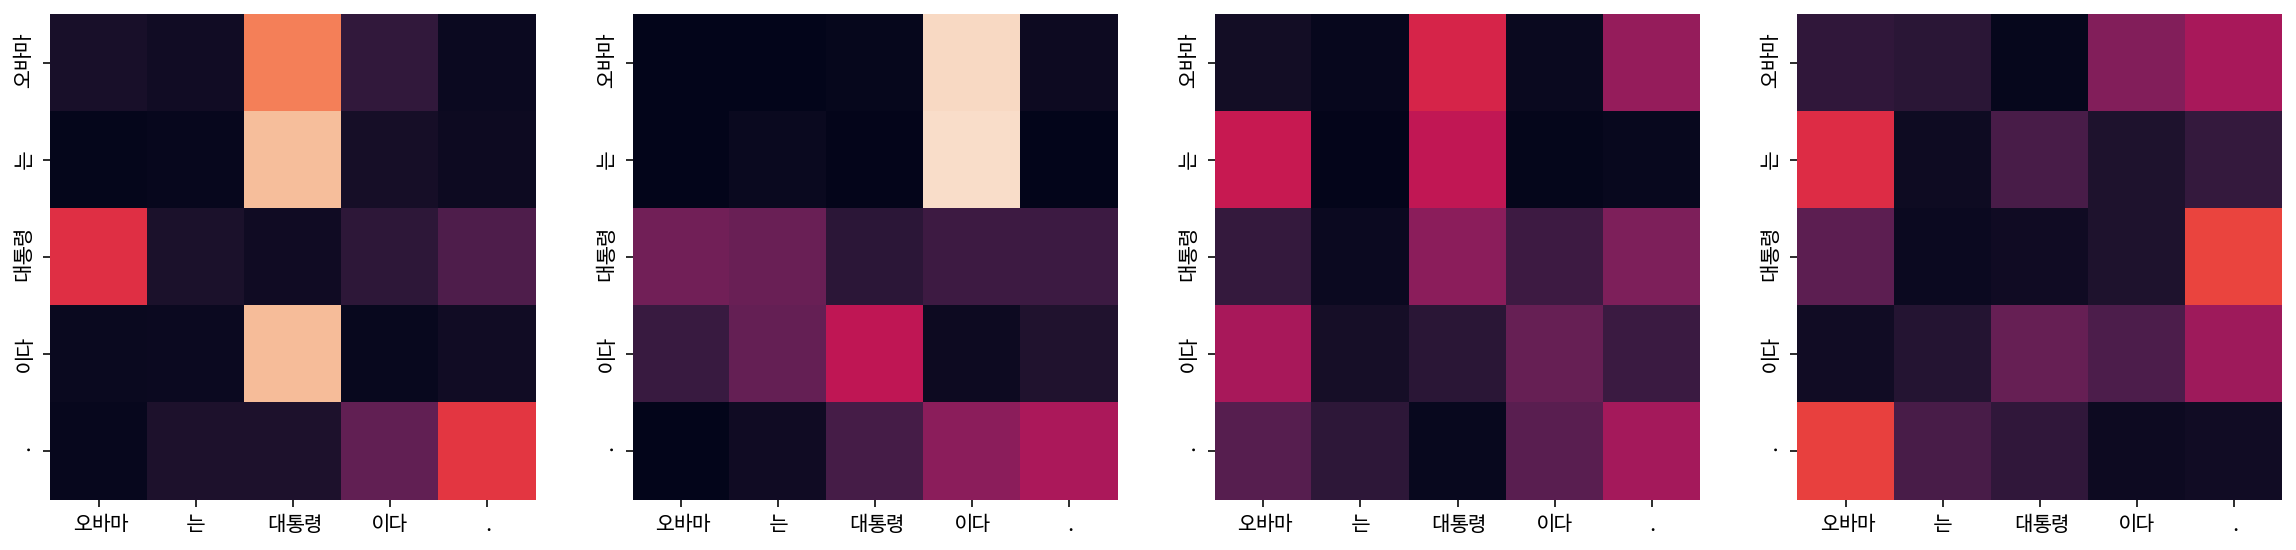

Decoder Self Layer 1


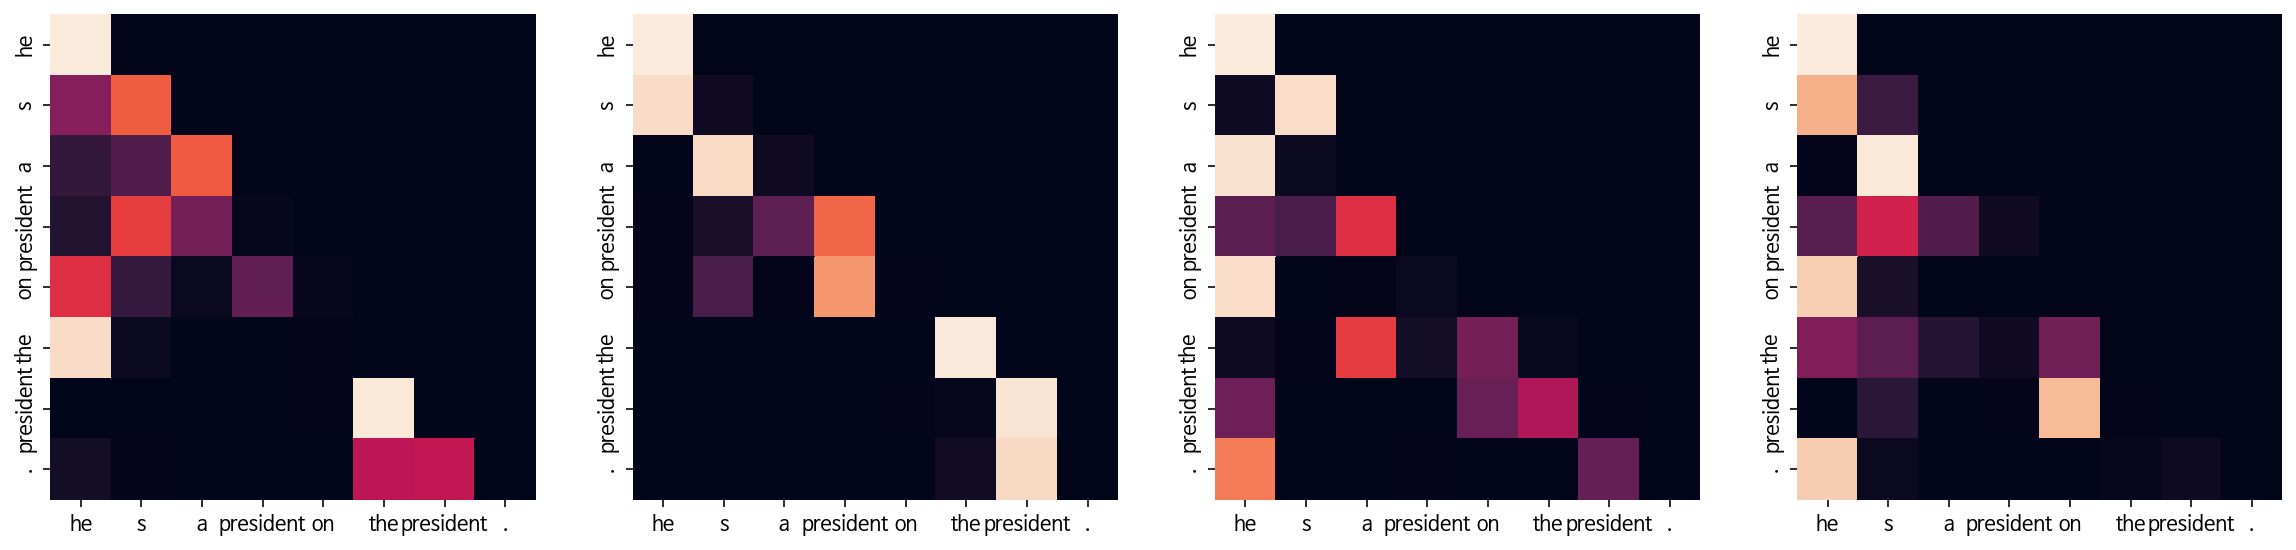

Decoder Src Layer 1


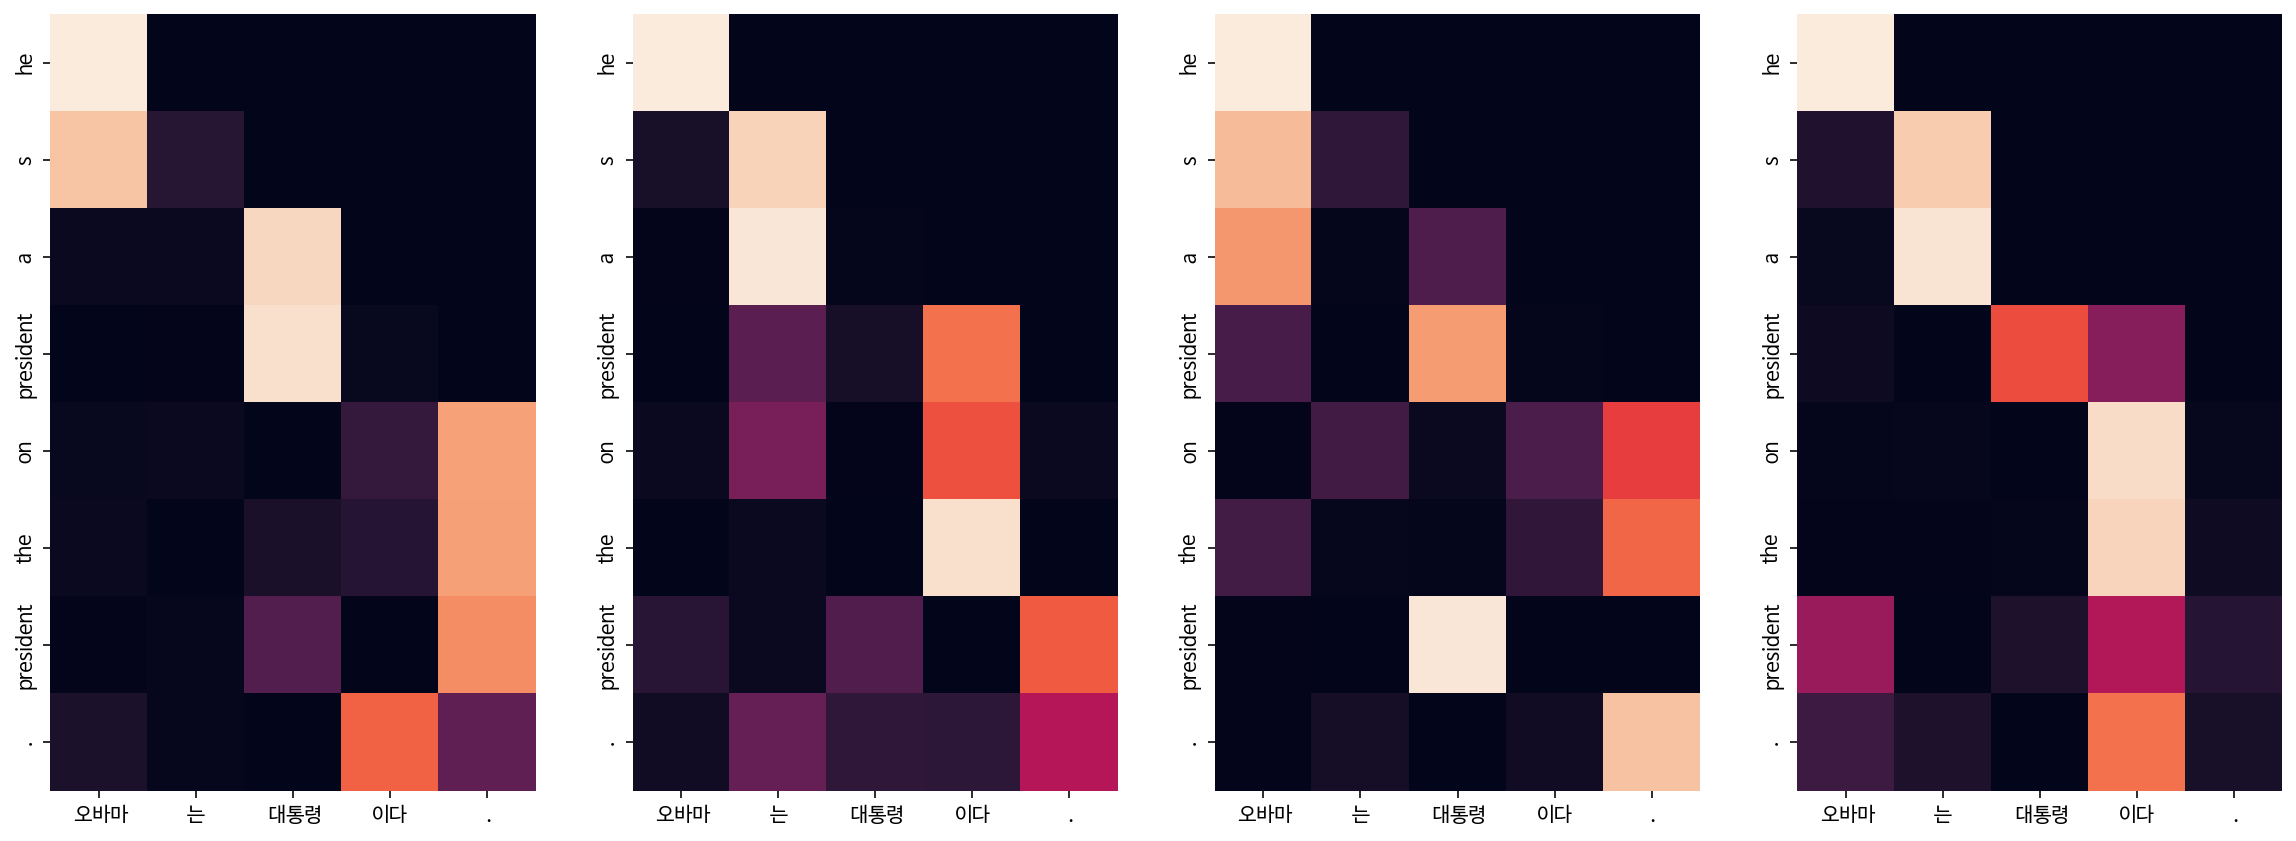

Decoder Self Layer 2


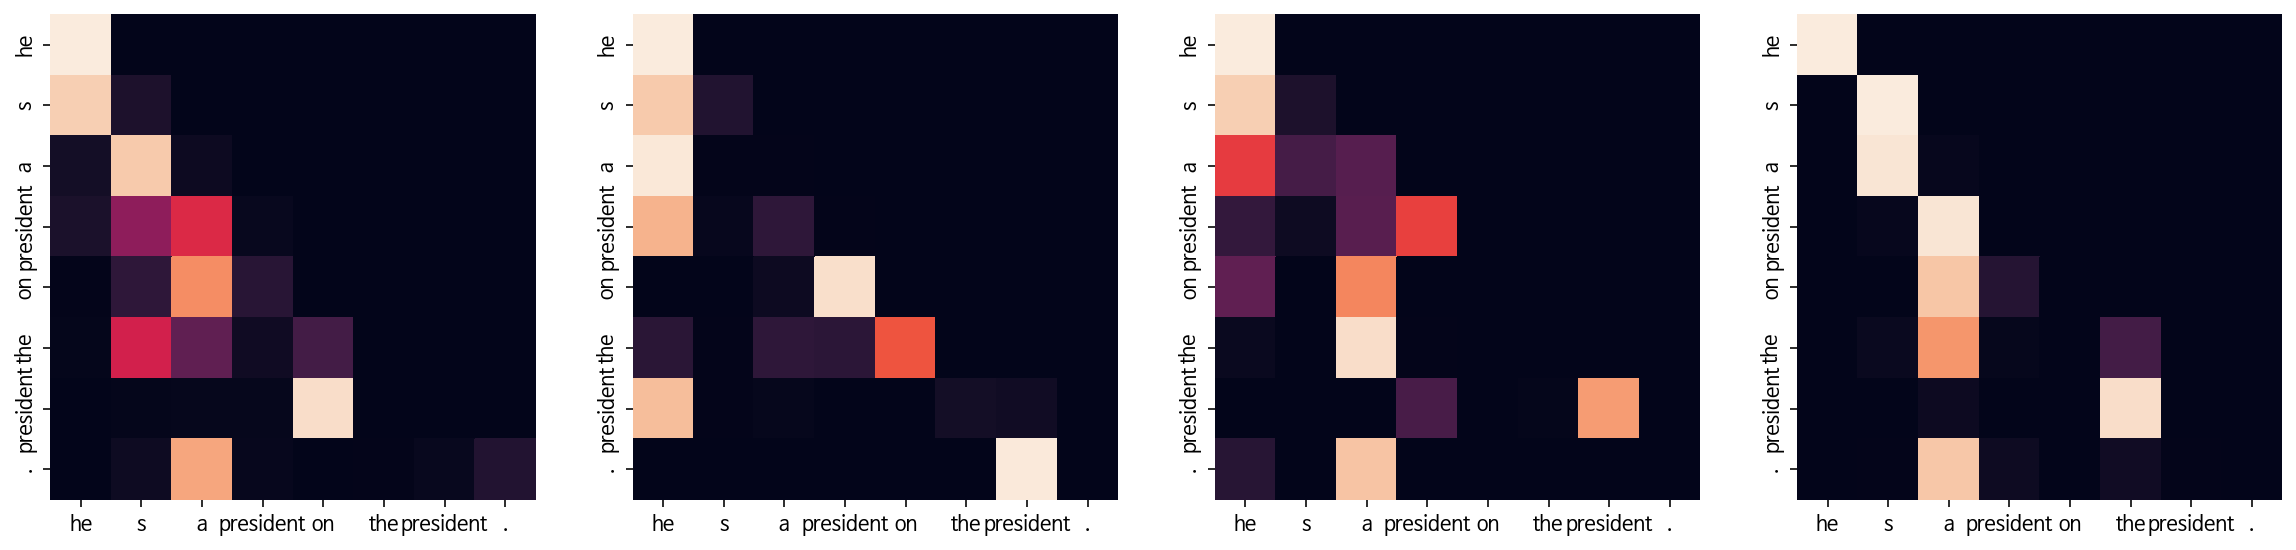

Decoder Src Layer 2


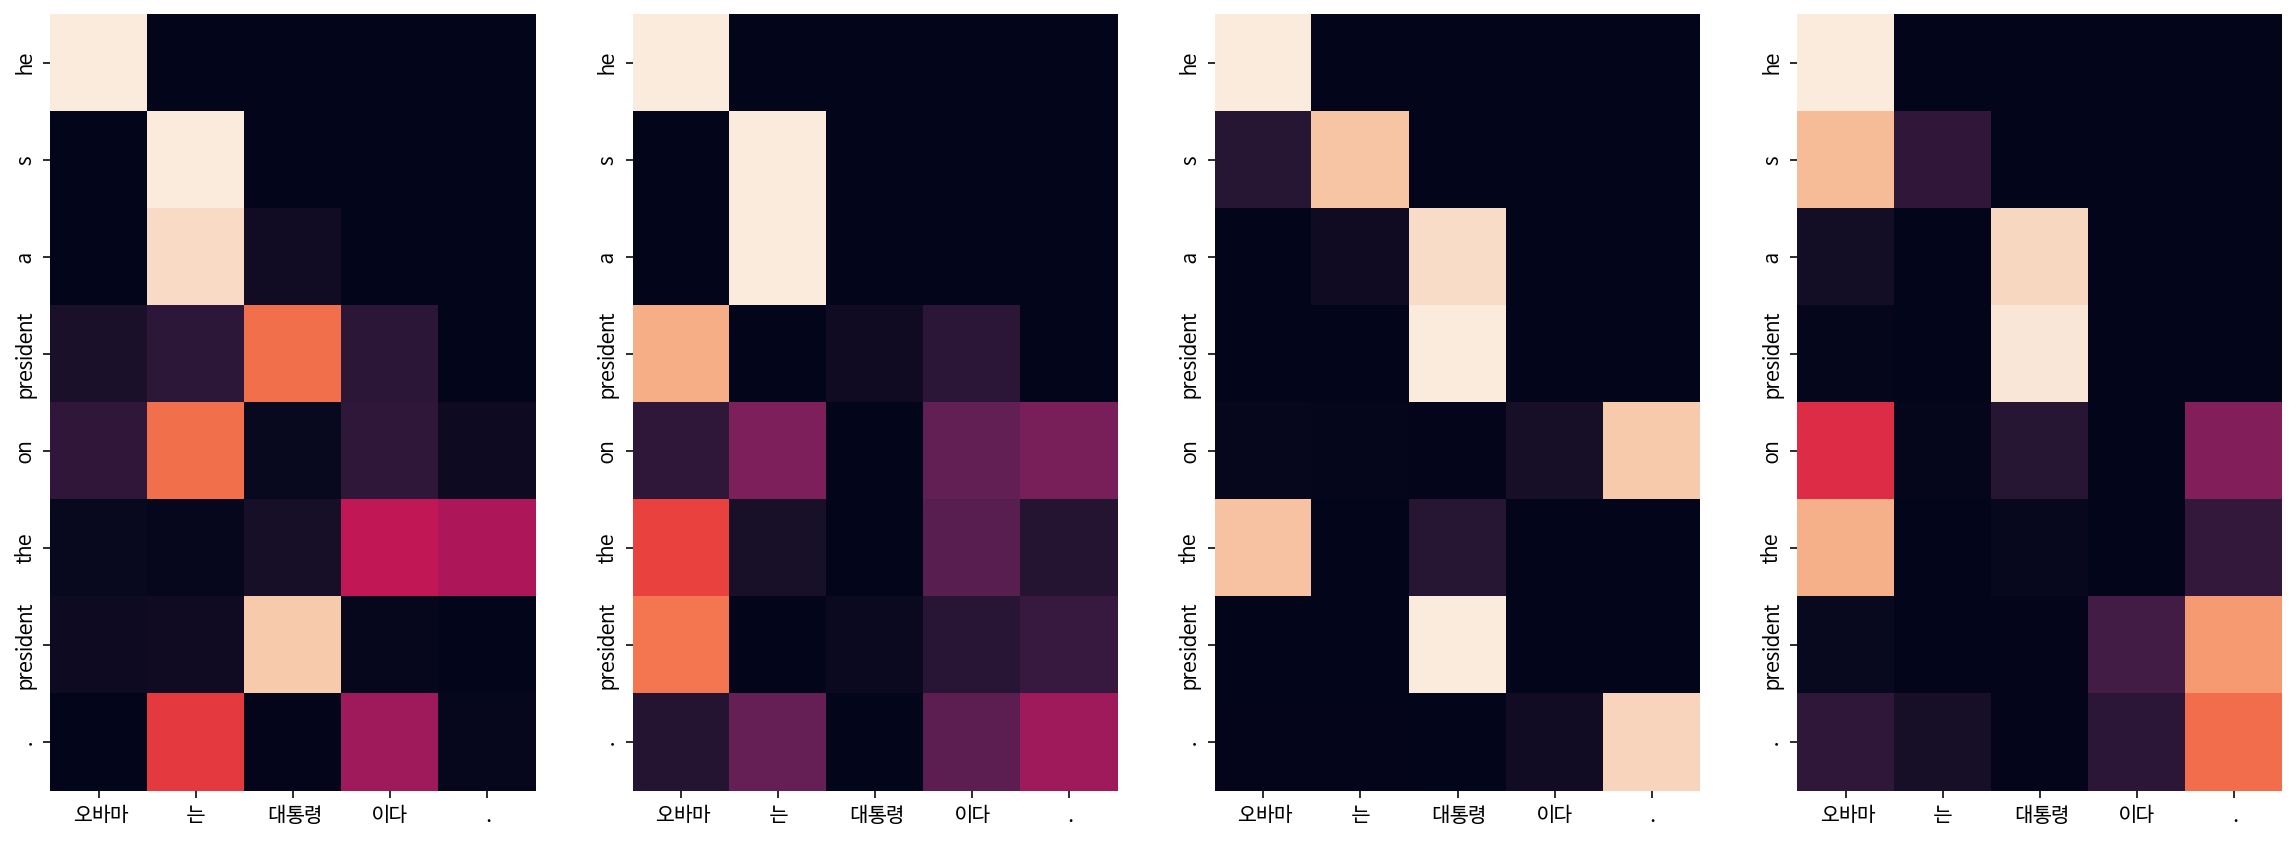

In [34]:
translate("오바마는 대통령이다.", transformer,kor_tokenizer, eng_tokenizer, True)

Input: 시민들은 도시 속에 산다.
Predicted translation: they now rial in the big cities .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


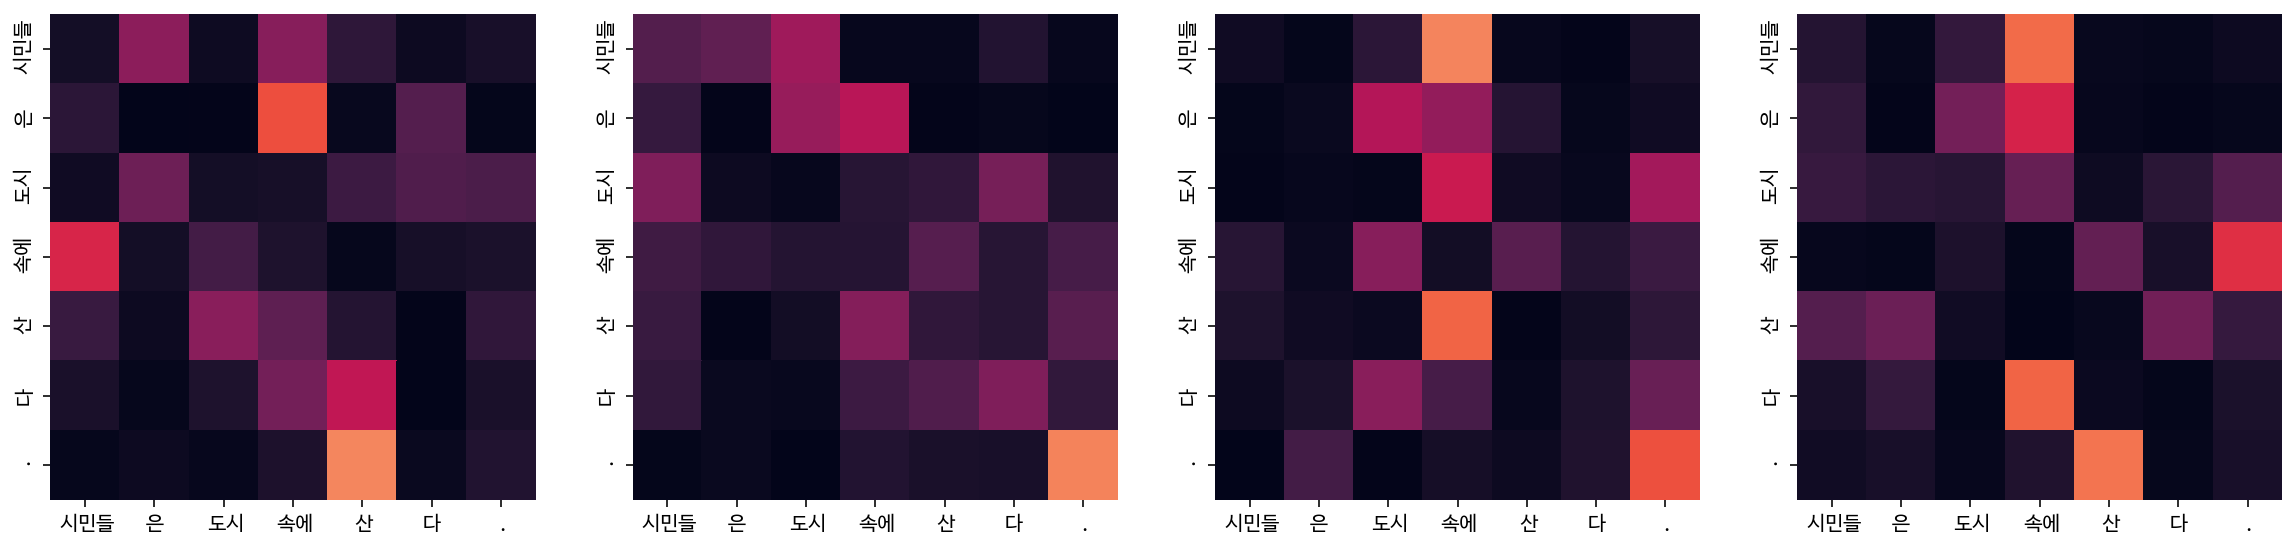

Encoder Layer 2


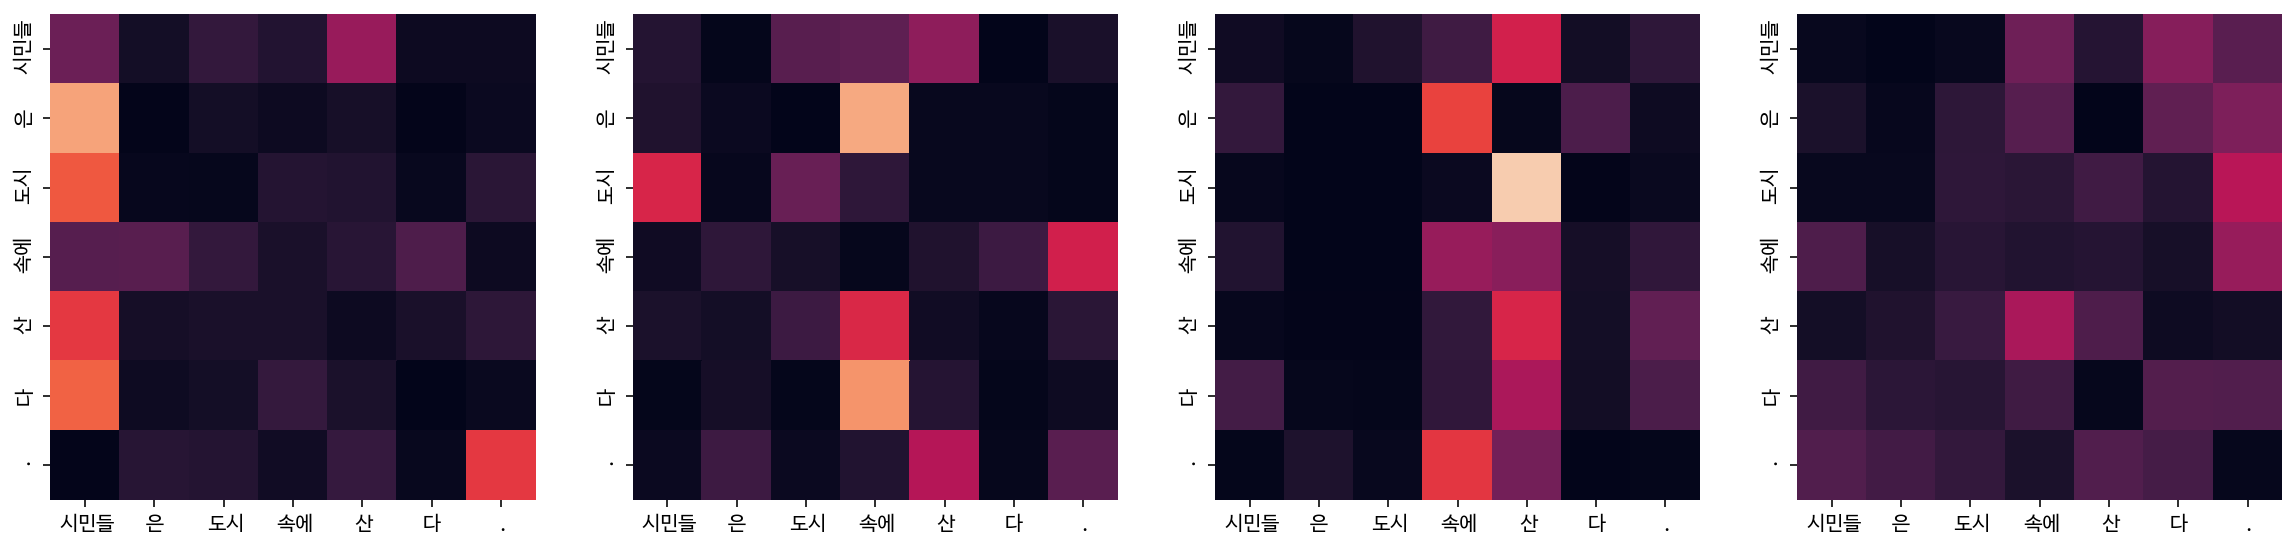

Decoder Self Layer 1


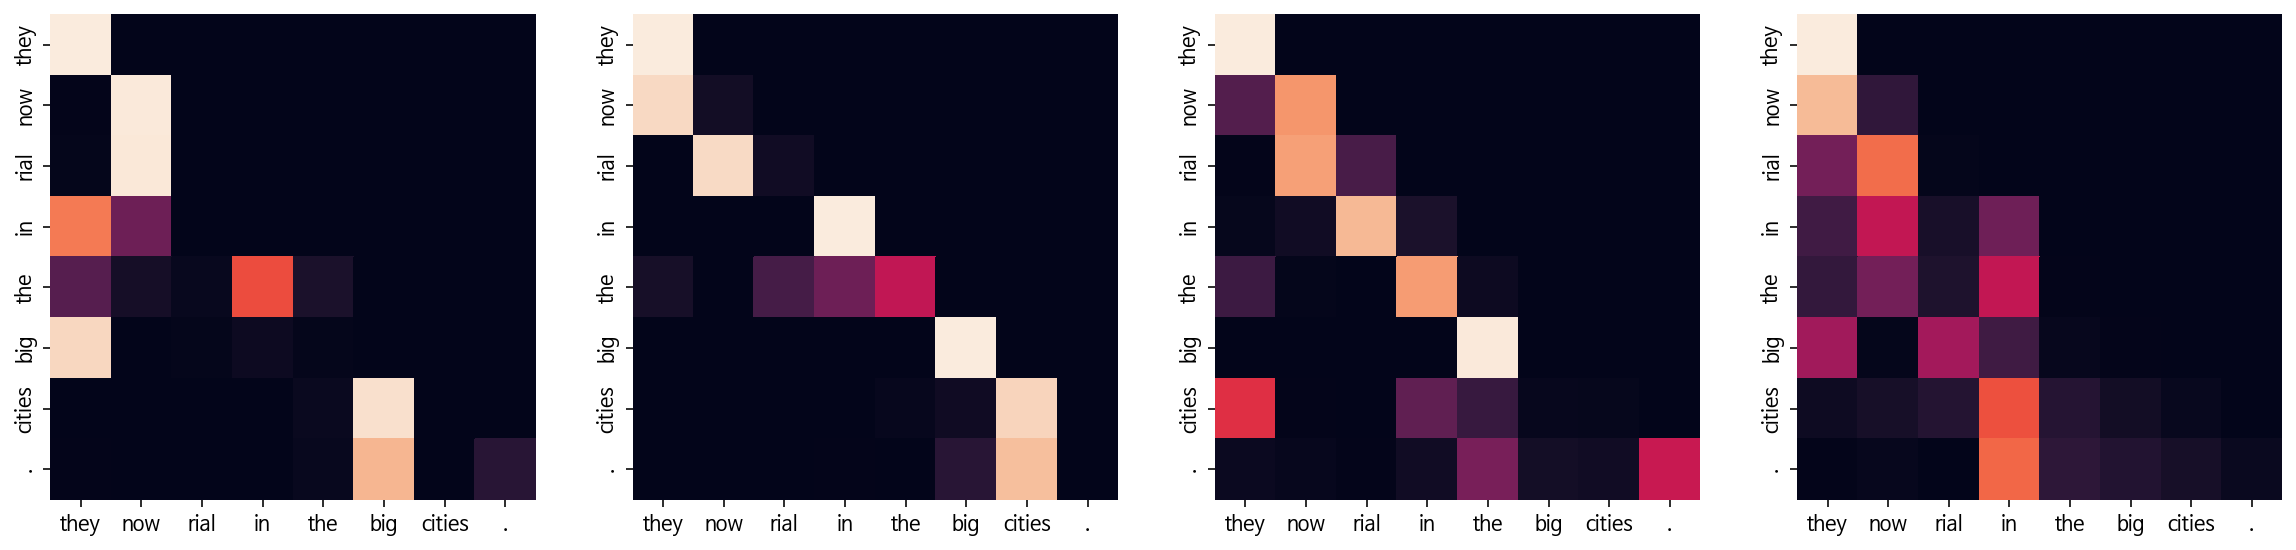

Decoder Src Layer 1


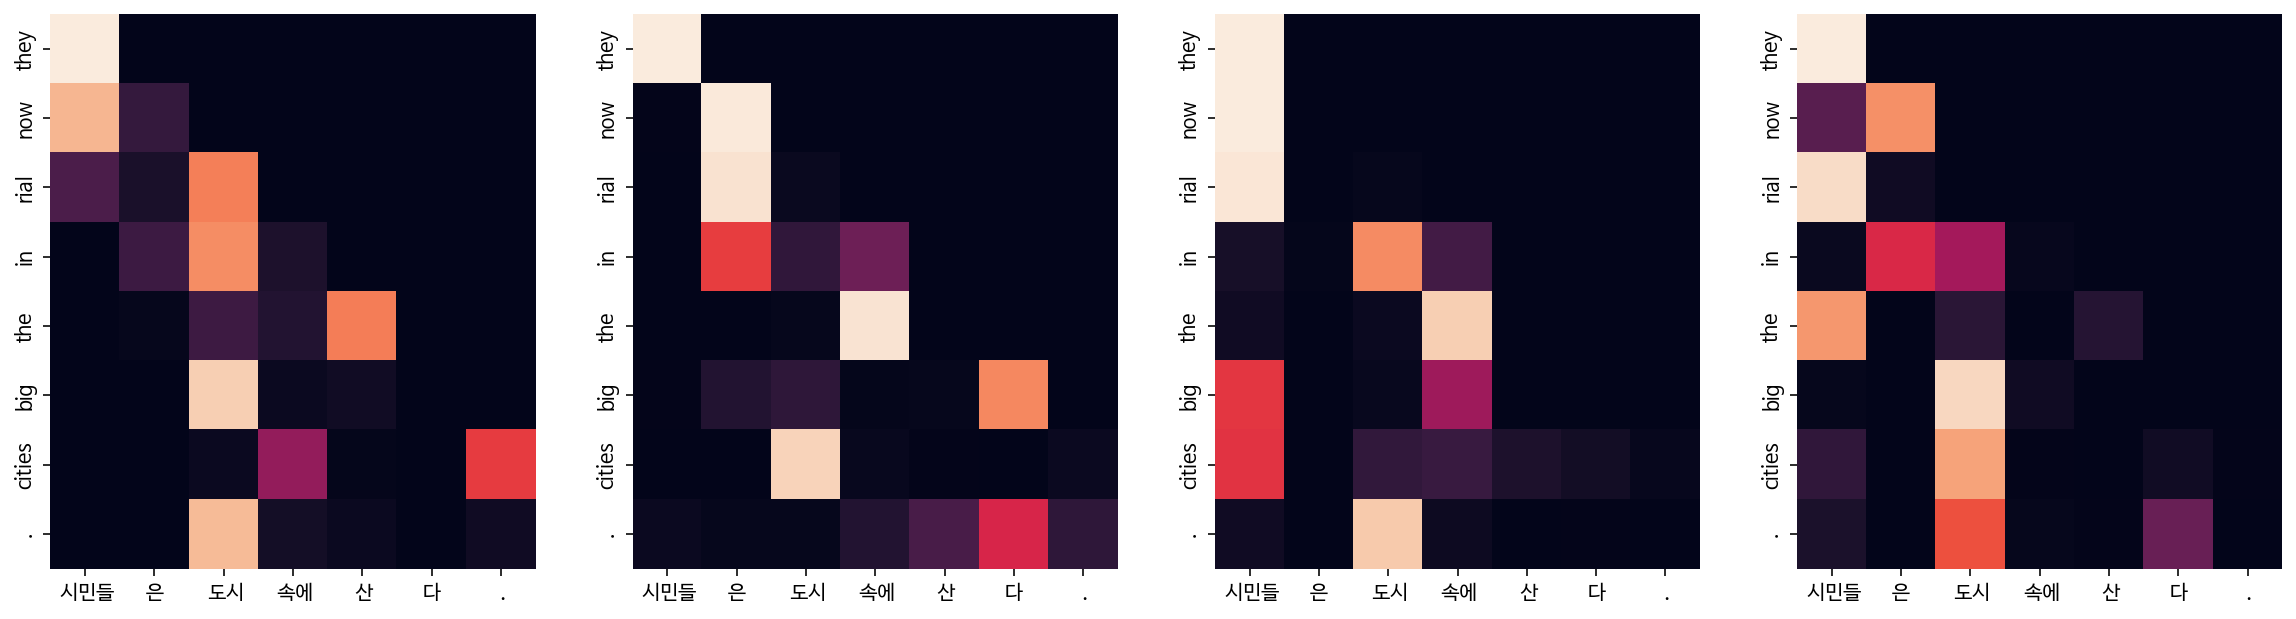

Decoder Self Layer 2


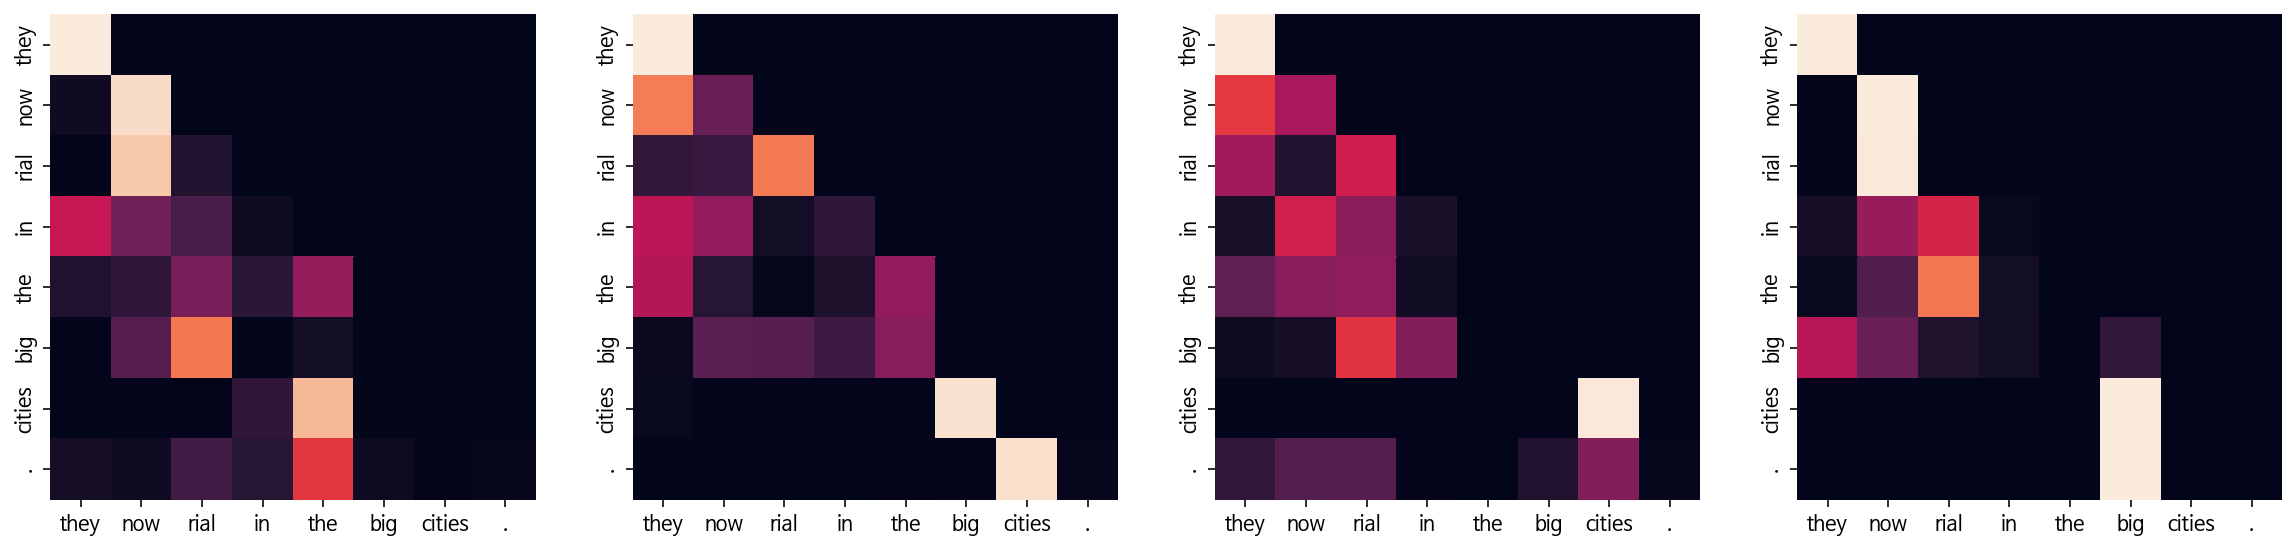

Decoder Src Layer 2


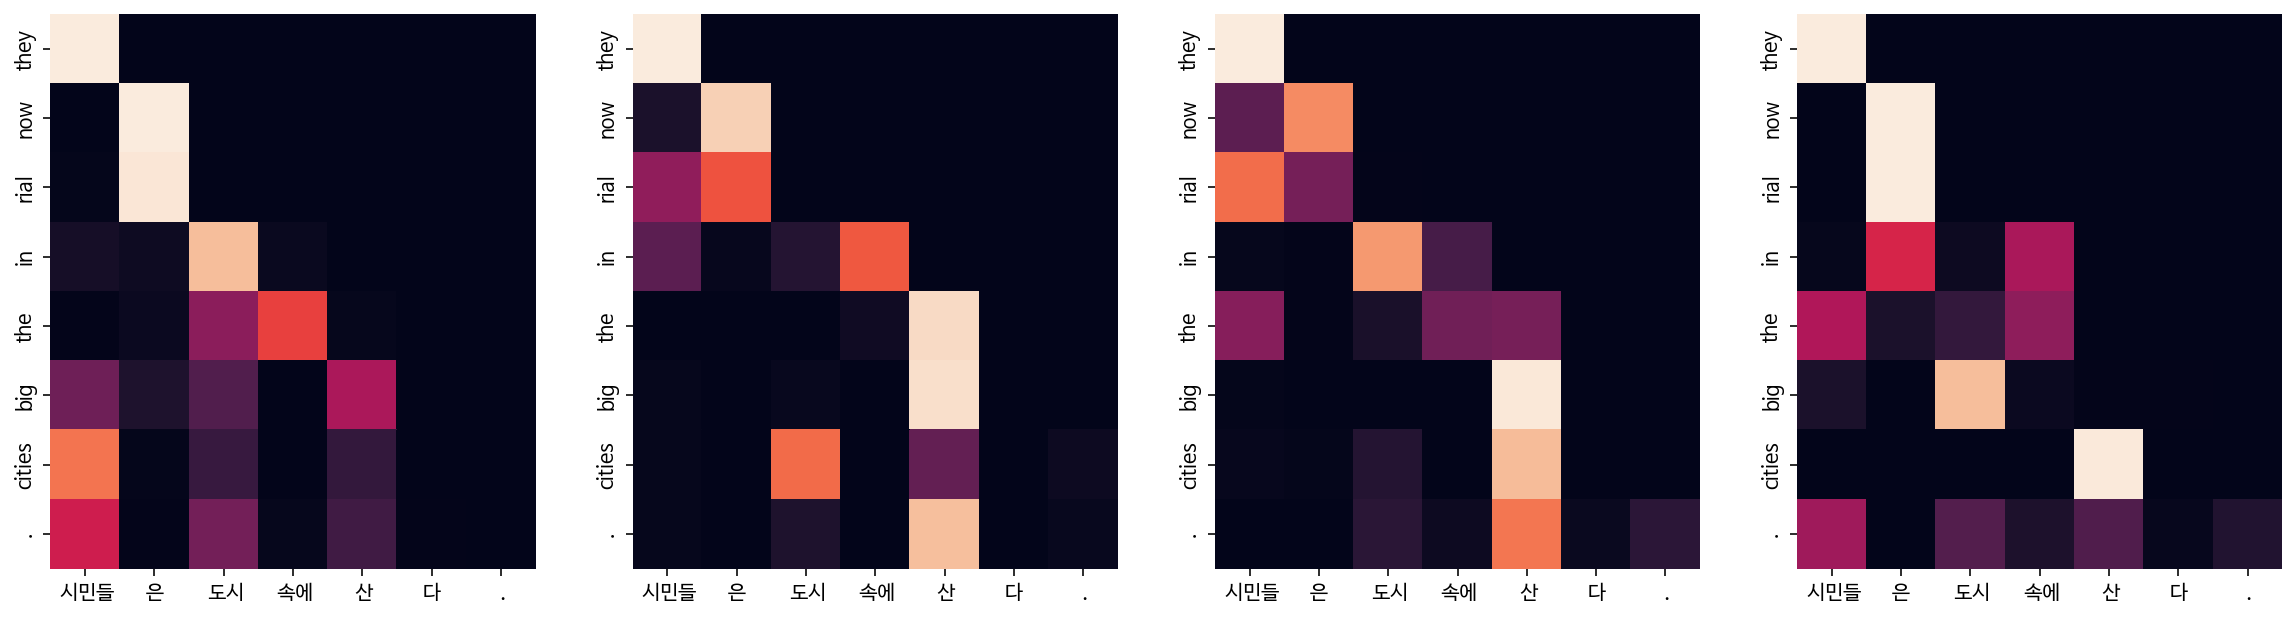

In [36]:
translate("시민들은 도시 속에 산다.", transformer,kor_tokenizer, eng_tokenizer, True)

Input: 커피는 필요 없다.
Predicted translation: need to coffee
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


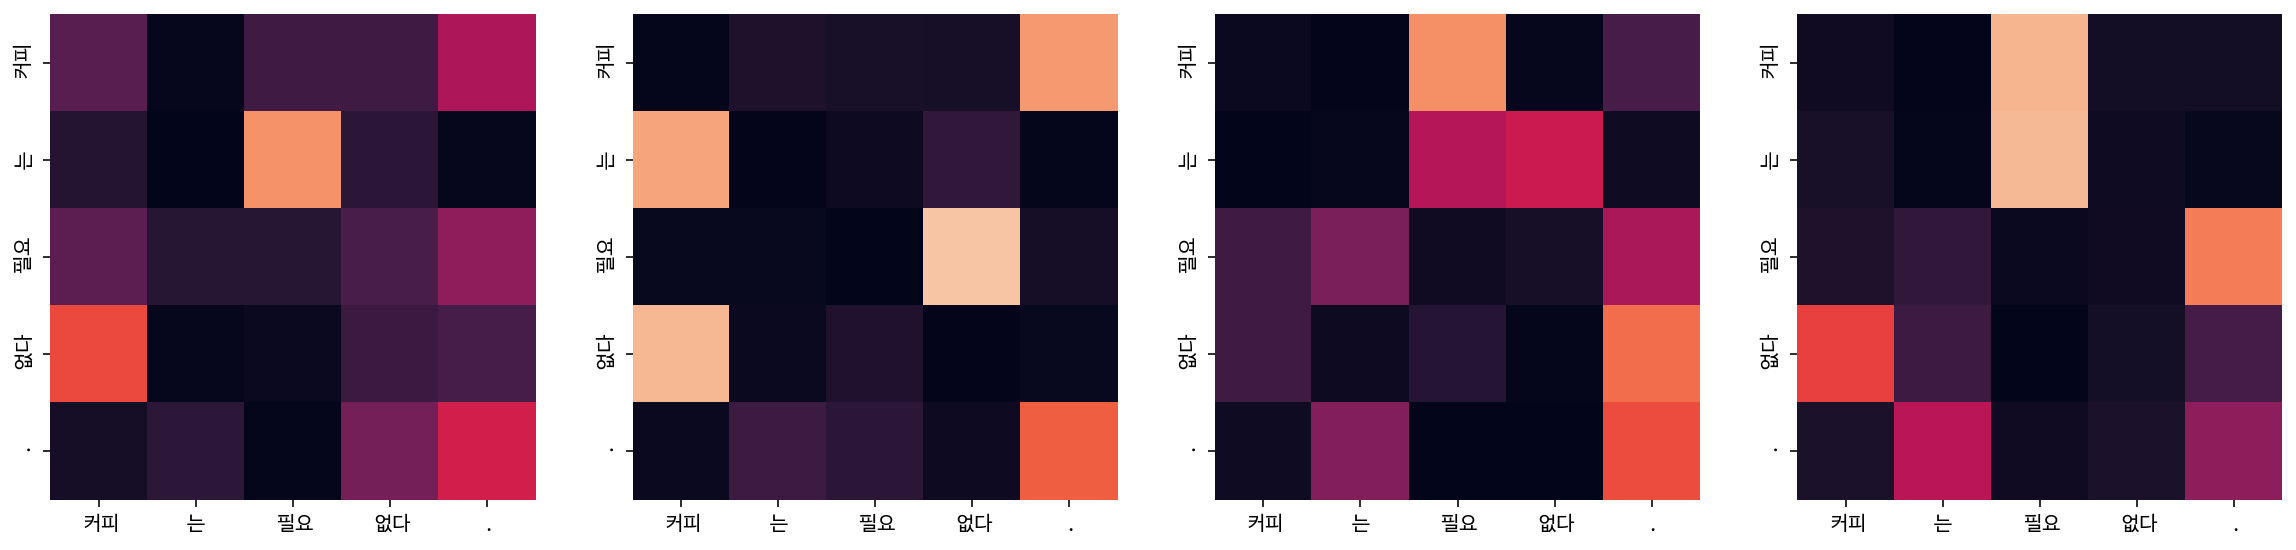

Encoder Layer 2


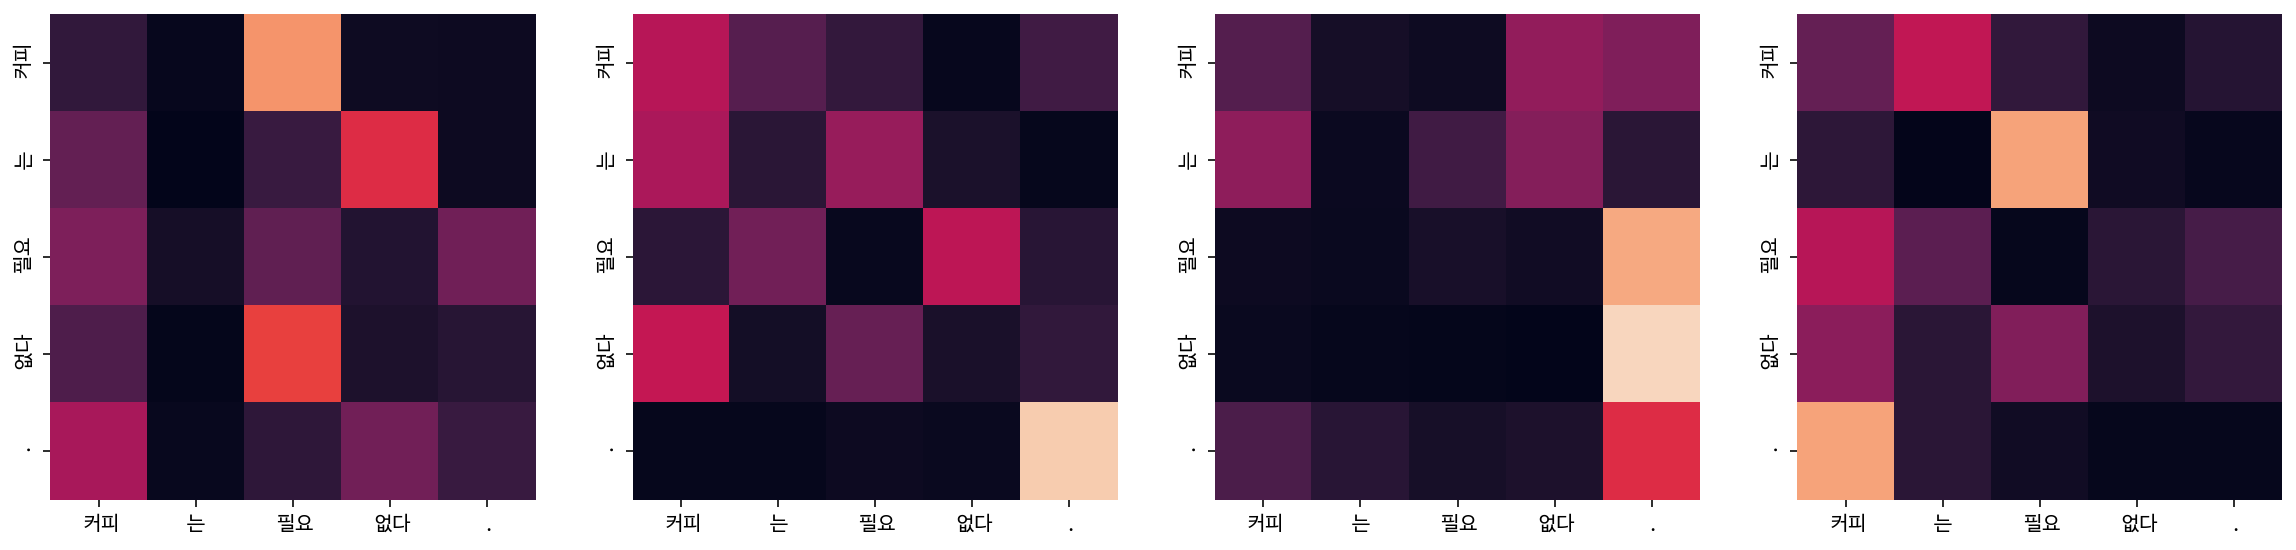

Decoder Self Layer 1


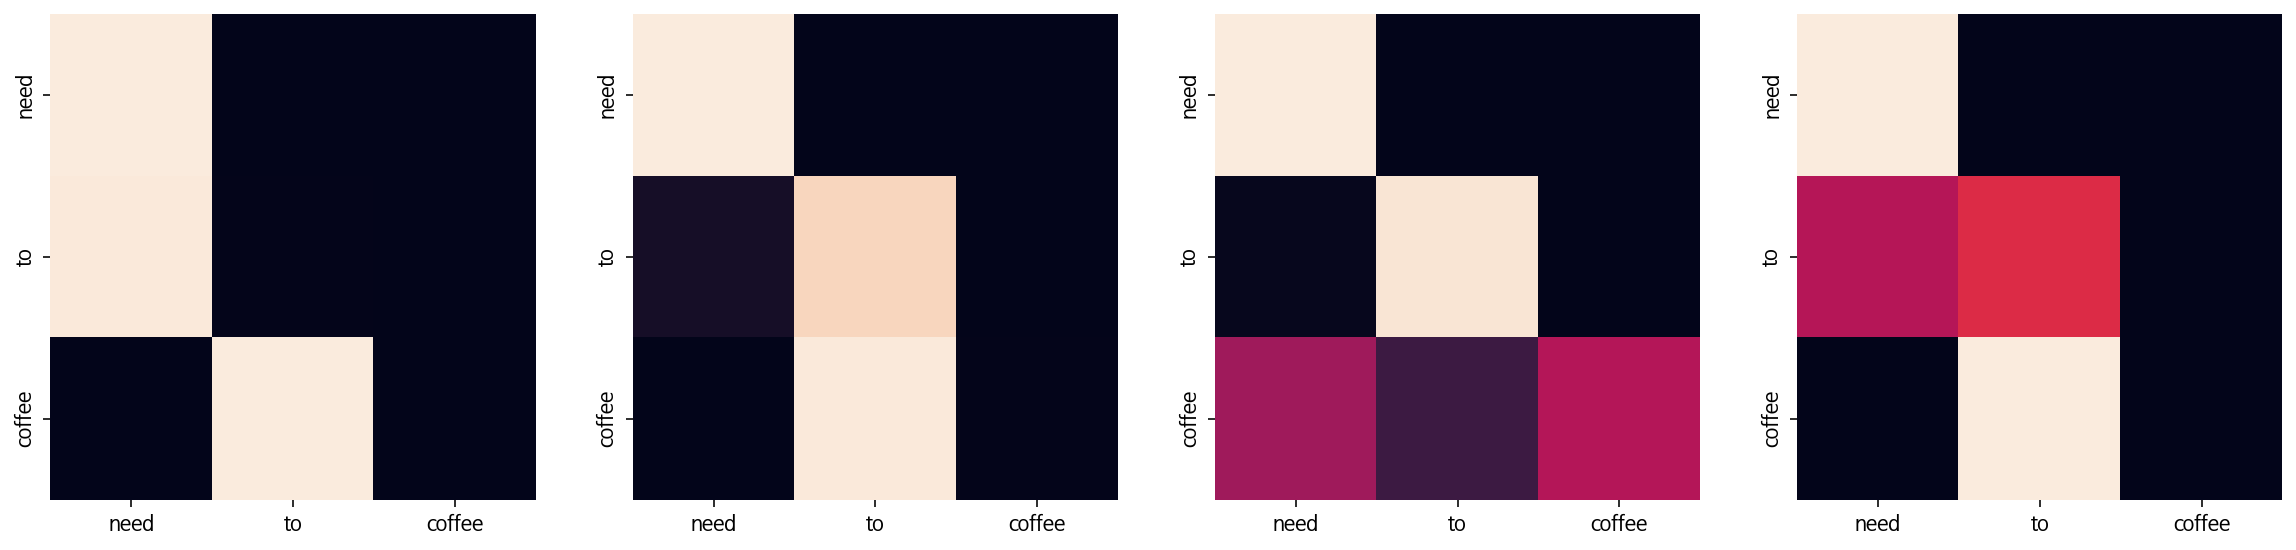

Decoder Src Layer 1


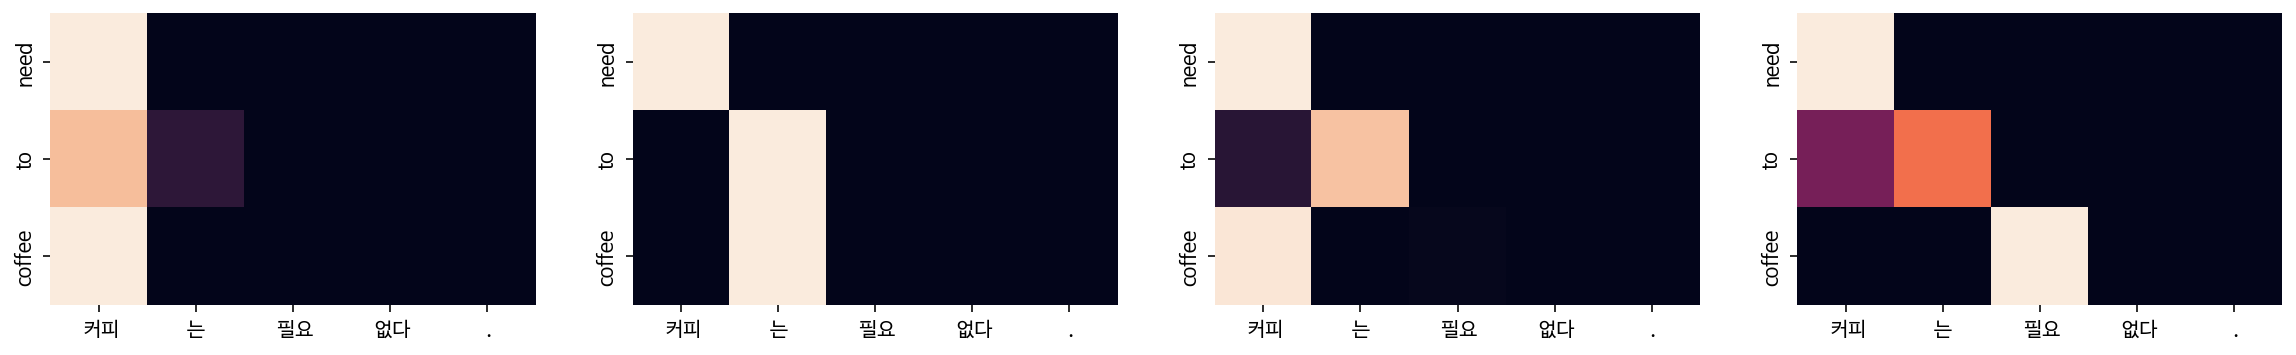

Decoder Self Layer 2


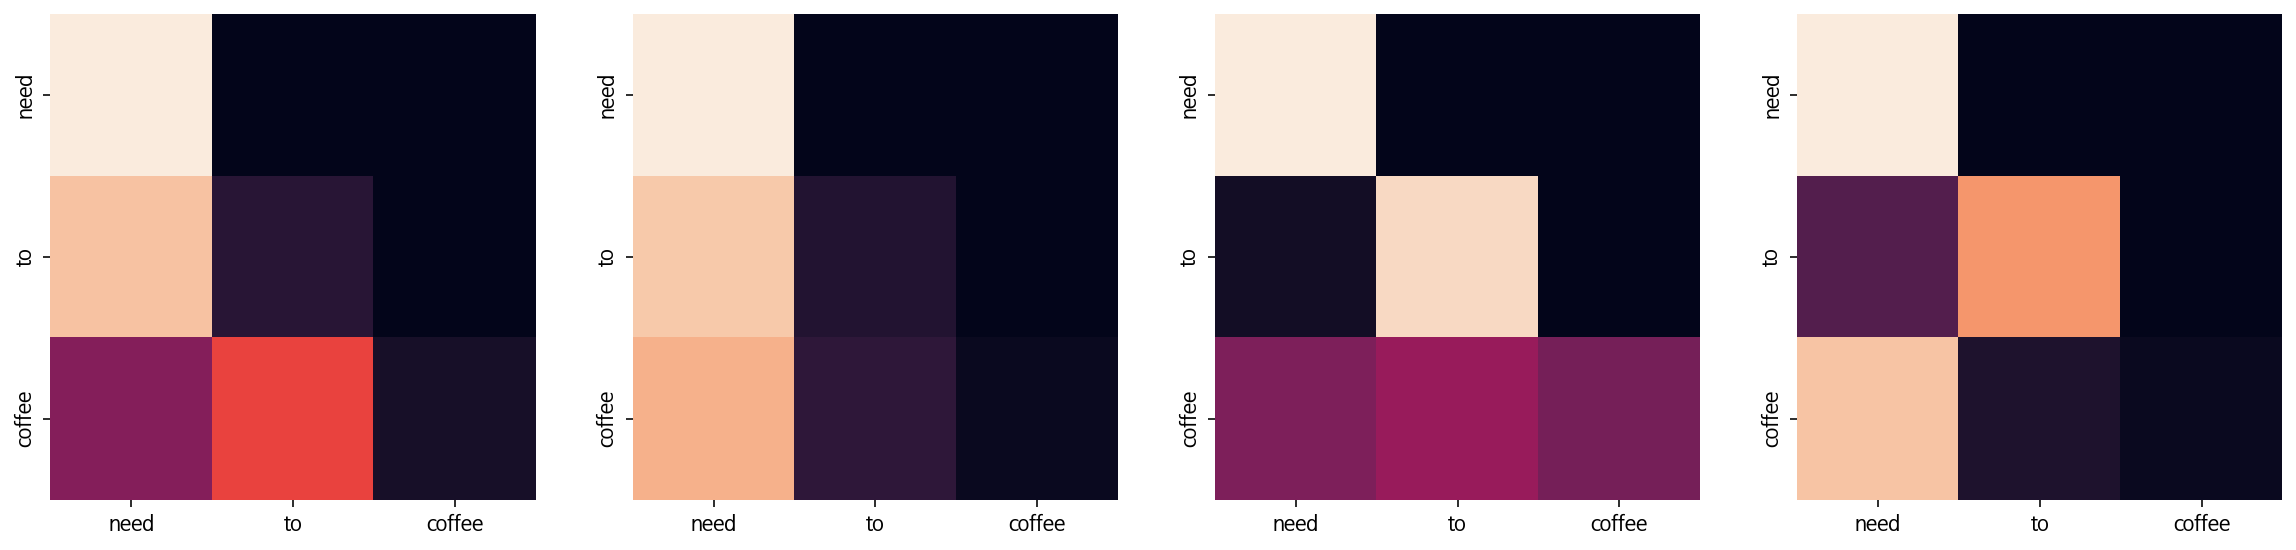

Decoder Src Layer 2


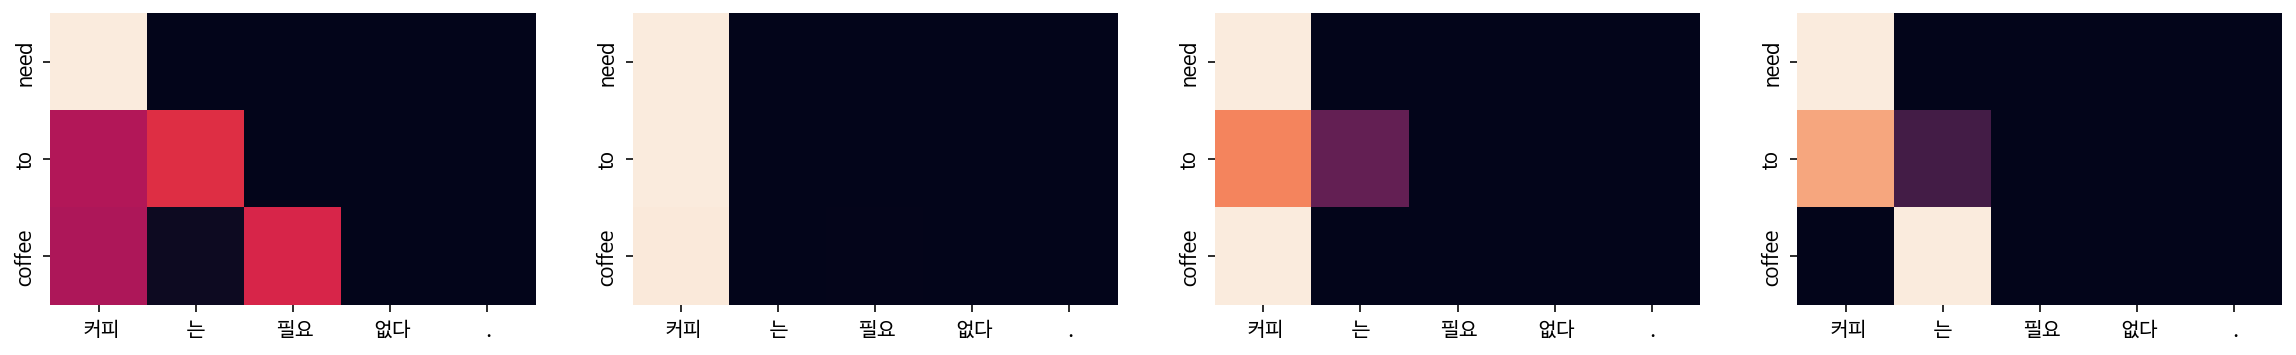

In [37]:
translate("커피는 필요 없다.", transformer,kor_tokenizer, eng_tokenizer, True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , seven others were injured .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


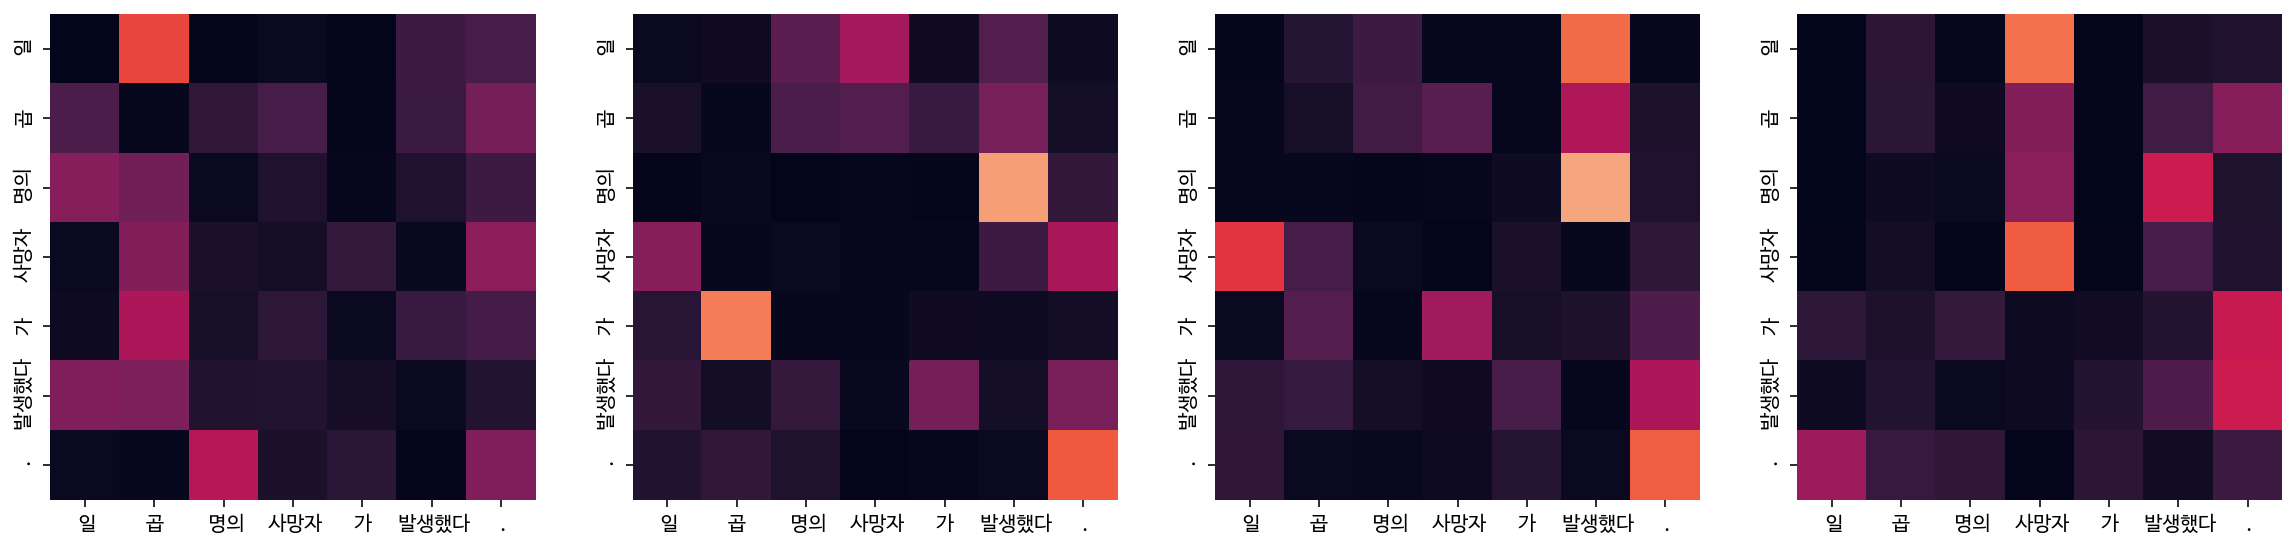

Encoder Layer 2


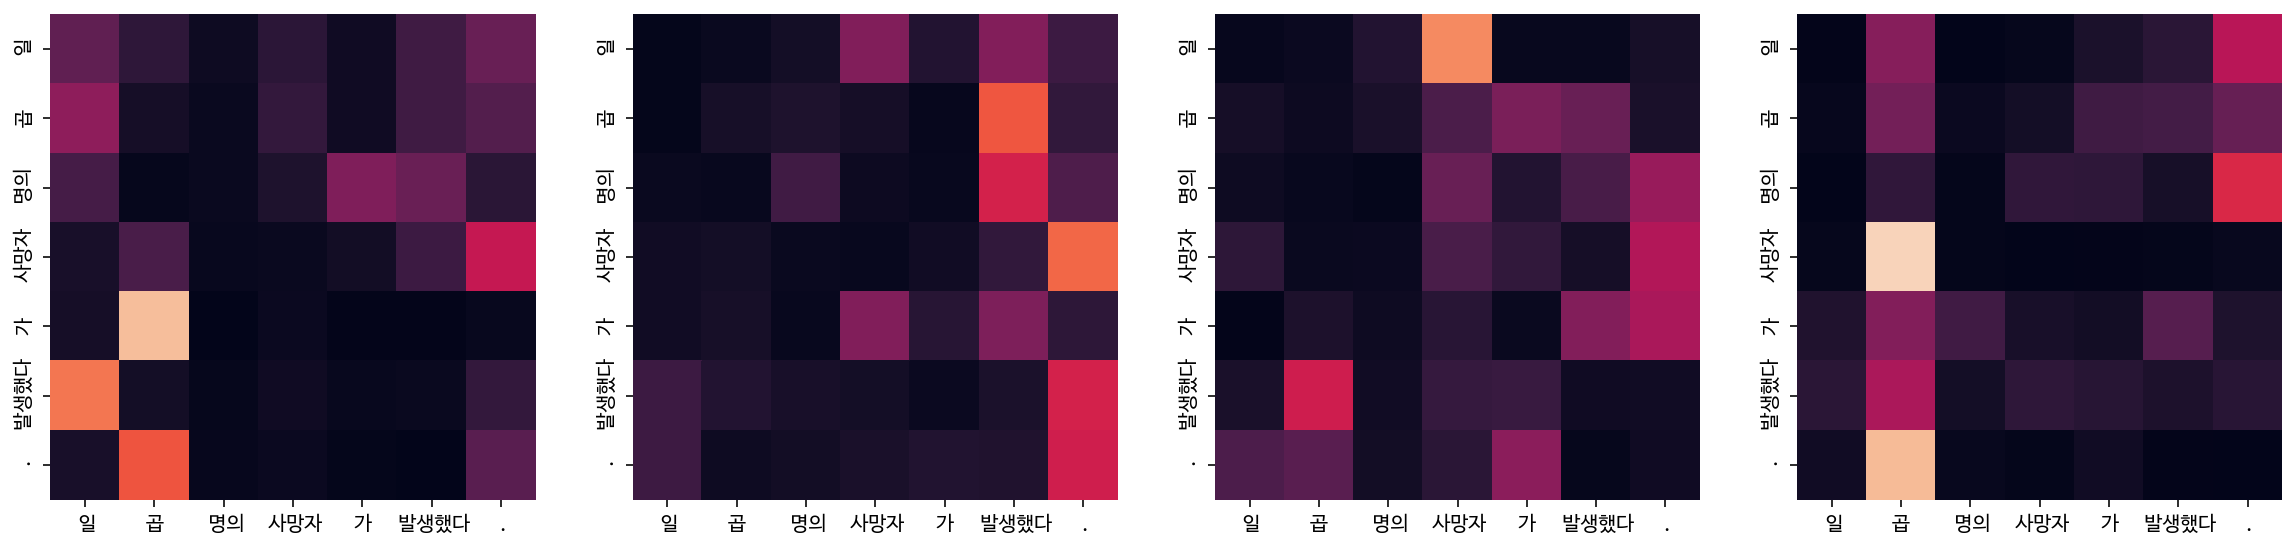

Decoder Self Layer 1


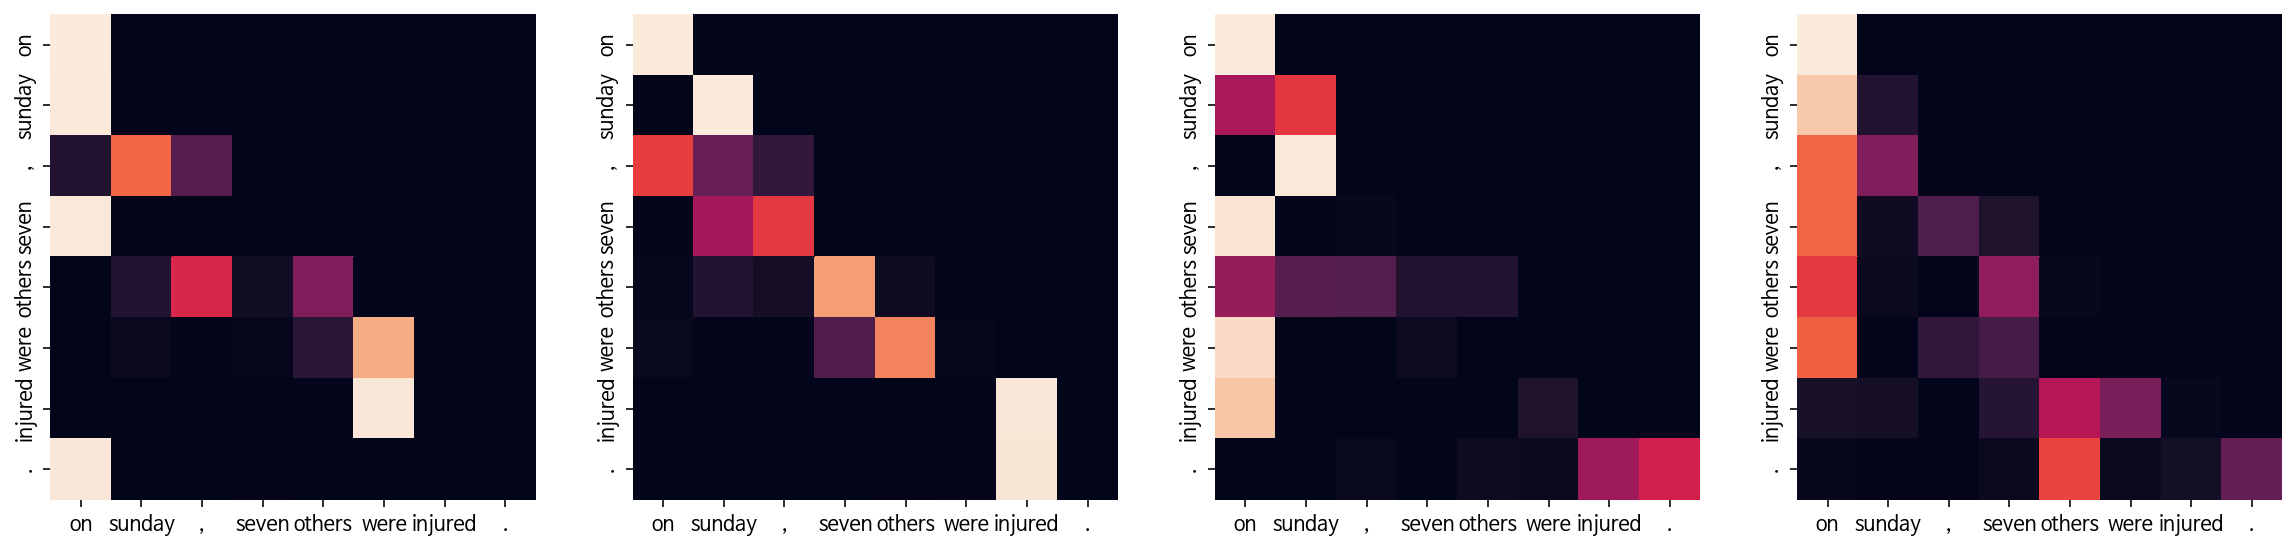

Decoder Src Layer 1


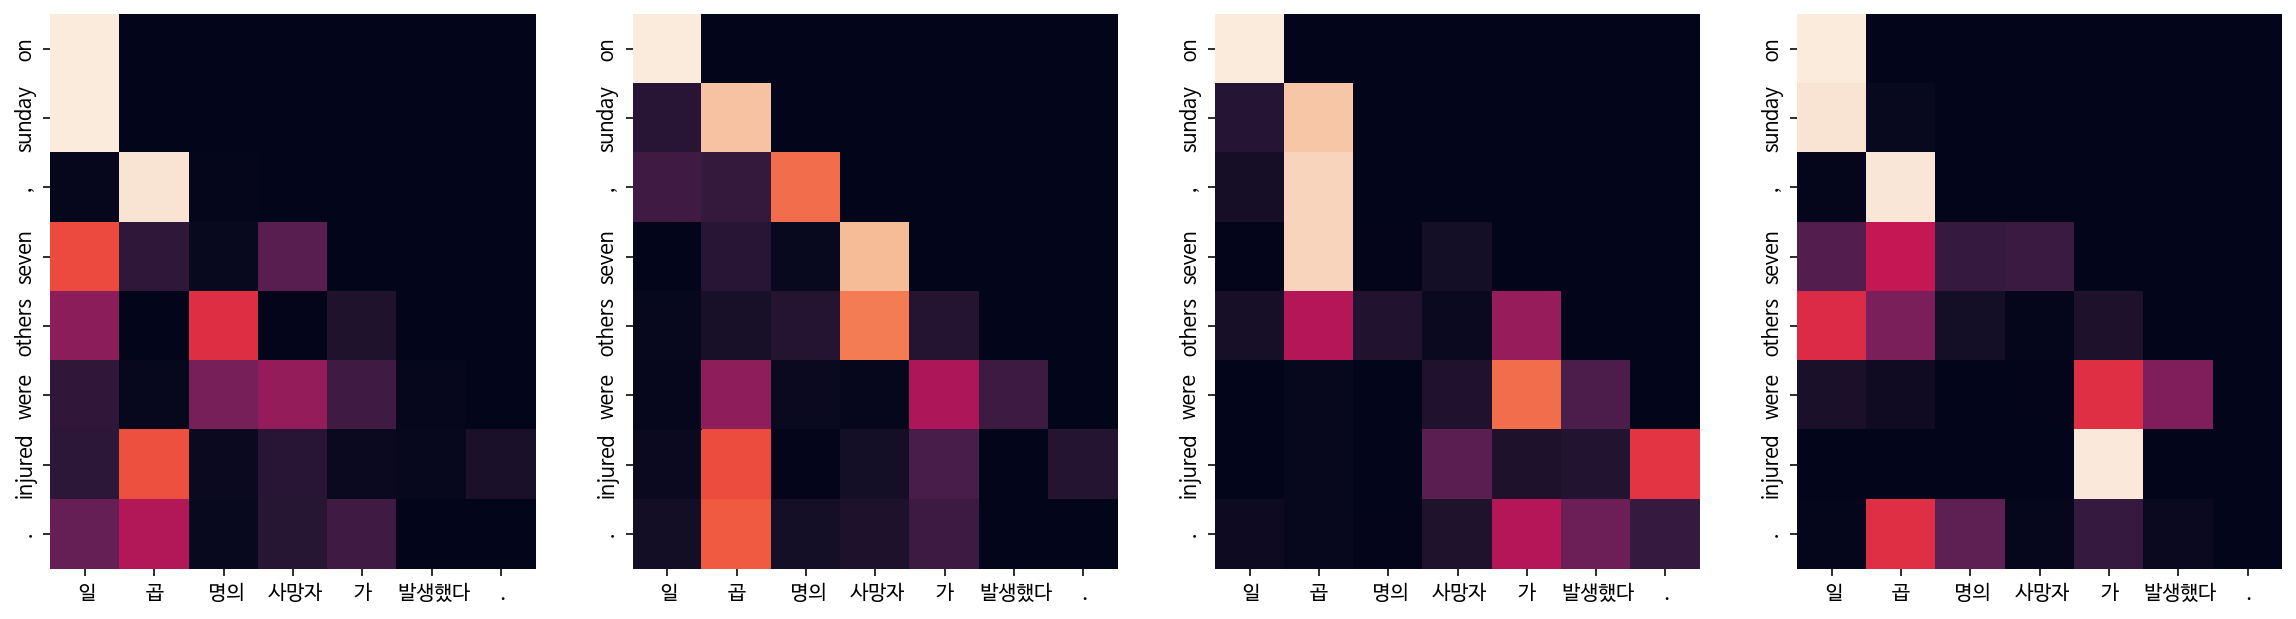

Decoder Self Layer 2


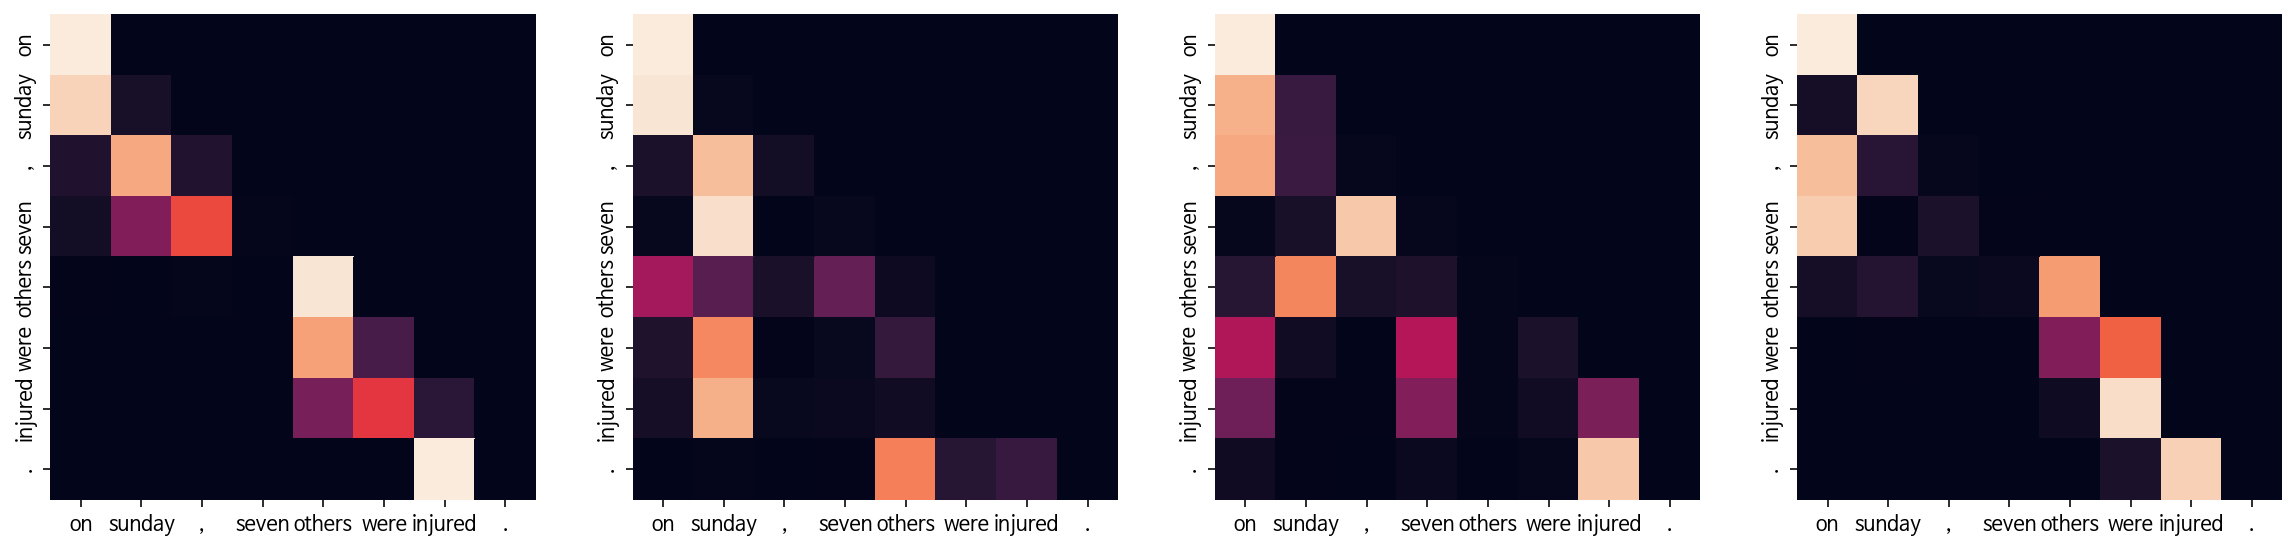

Decoder Src Layer 2


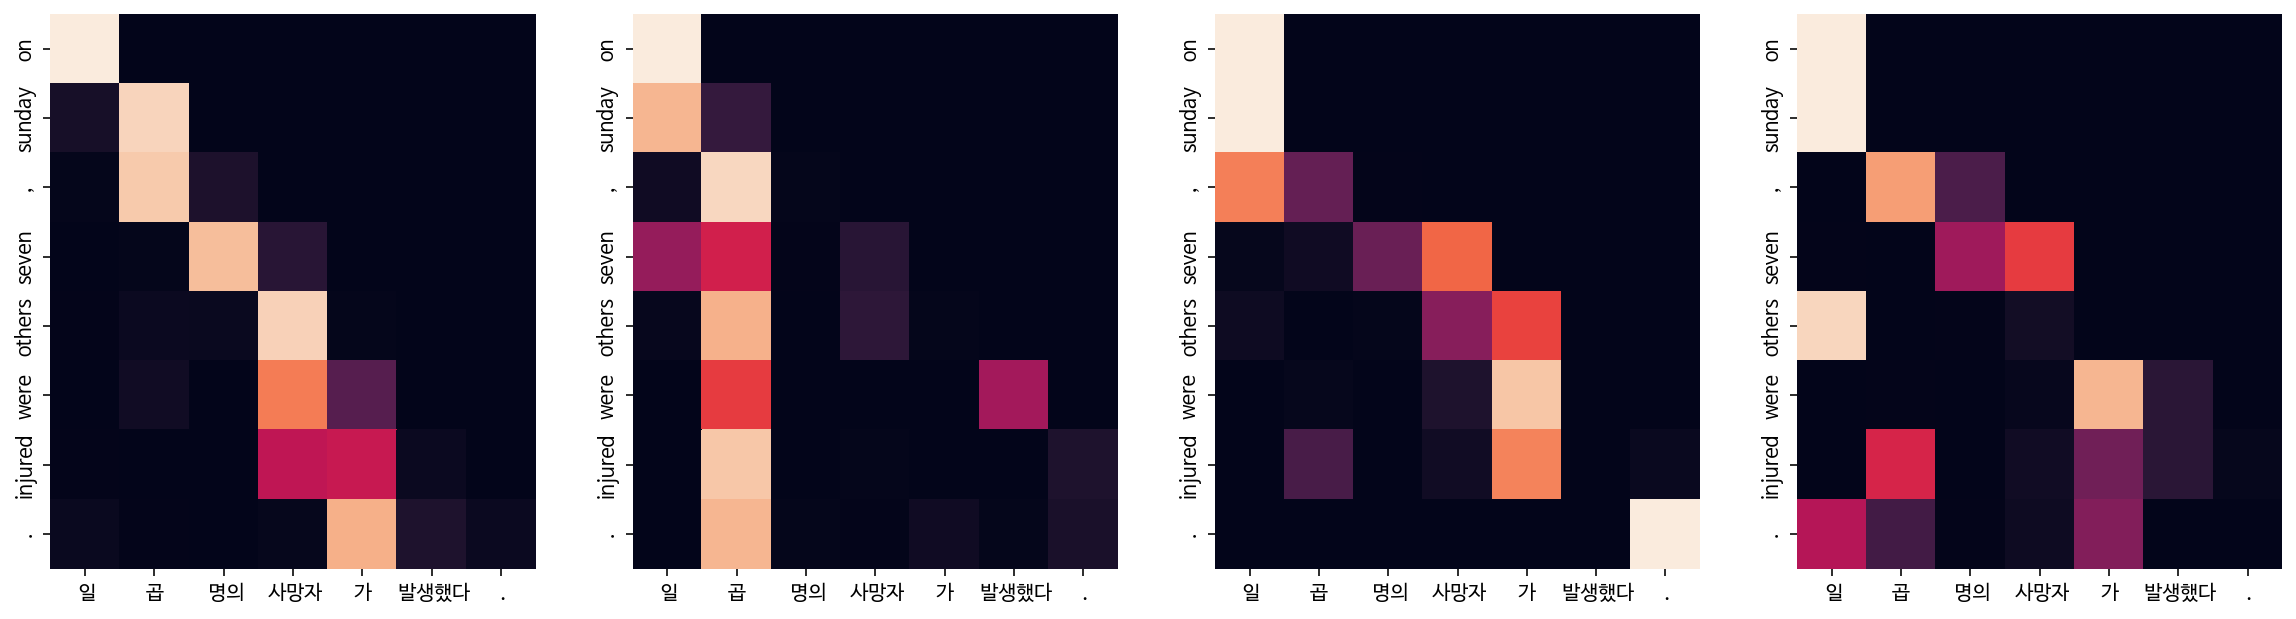

In [38]:
translate("일곱 명의 사망자가 발생했다.", transformer,kor_tokenizer, eng_tokenizer, True)

# **🌞 회고**
---

## **1) 결과**
> - 오바마는 대통령이다. ▶ he s a president on the president .
> - 시민들은 도시 속에 산다. ▶ they now rial in the big cities .
> - 커피는 필요 없다. ▶ need to coffee
> - 일곱 명의 사망자가 발생했다. ▶ on sunday , seven others were injured .

-  `Transformer`를 사용하면 더 성능이 좋을 거라고 생각했지만, 생각보다 번역이 잘 되지 않았다.
- epoch이나 layer 수 하이퍼파라미터를 변경하면 더 성능이 나아졌을까 하는 생각이 들지만 좋은 결과를 얻기는 쉽지 않을 것 같다.

[Attention만을 사용한 결과]
> - 오바마는 대통령이다. ▶ obama is a lot of winning .
> - 시민들은 도시 속에 산다. ▶ they are in the city .
> - 커피는 필요 없다. ▶ but it s not a cadillac , but it s not a cadillac , but it s not a cadillac , but it s not a cadillac , but it s not a cadillac , but it s not a
> - 일곱 명의 사망자가 발생했다. ▶ seven people were killed .

- Transformer를 사용하지 않았을 때와 결과가 큰 차이가 없다.
- 주요 키워드는 잘 잡아내는 것 같으나 정확하게 번역이 되지 않는다.

## **2) 후기**
- 다양한 시도를 해보지 않아서 그런가, 결과가 아쉽게 나왔다.
- `Transformer`는 여전히 어렵다... 계속해서 공부를 해서 내것으로 만들어봐야겠다...!!!!